<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BCS" data-toc-modified-id="BCS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BCS</a></span></li><li><span><a href="#VQD-Example" data-toc-modified-id="VQD-Example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>VQD Example</a></span></li><li><span><a href="#Varying-epislon" data-toc-modified-id="Varying-epislon-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Varying epislon</a></span></li></ul></div>

# BCS

Using the Paper by [Wu et al.](https://arxiv.org/abs/quant-ph/0108110), we have that:

The BCS hamiltonian is:

$$H_{BCS} = \sum_{m=1}^N \frac{\epsilon_m}{2} ( n_m^F + n_{-m}^F ) + \sum_{m,k=1}^N V^{+}_{ml} c^\dagger_m c^\dagger_{-m} c_{-l}c_l$$

Where $n_{\pm m}^F = c^\dagger_{\pm m} c_{\pm m}$, and the matrix elements $V^+_{ml} = \langle m, -m| V | l, -l \rangle$.

Which is mapped into:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m + \sum_{r= \pm l} \sum_{l>m=1}^N \frac{V_{ml}^r}{2} ( \sigma^x_m \sigma^x_l + r \sigma^y_m \sigma^y_l )$$

where $\epsilon_m = \epsilon_m + V^+_{mm}$ and $V^-_{ml} = 0$ for the BCS Hamiltonian, thus:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m +  \sum_{l>m=1}^N \frac{V_{ml}}{2} ( \sigma^x_m \sigma^x_l +  \sigma^y_m \sigma^y_l )$$

$l \ \mathrm{and} \ m$ now denote both state and qubit indices. In this case the qubit state space $H_P = Span \{ |0 \rangle, \sigma^+_m |0 \rangle, \sigma_l^+ \sigma_m^+ |0 \rangle, \dots   \}$ is mapped into a subspace where $n_m^F = n^F_{-m}$. Considering $V_{ml} = V$, we have that:

$$
H_p = \hbar \bigg[ \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma_z^m + \frac{V}{2} \sum_{l>m=1}^N (\sigma_x^m \sigma_x^l + \sigma_y^m \sigma_y^l) \bigg]
$$

This leads to a spectrum of $E_0^{\pm} = \pm(\epsilon_0 + \epsilon_1)/2$, $E_1^{\pm} = \pm \sqrt{\epsilon^2 + 4V^2}/2$, where $\epsilon^2 = (\epsilon_0 - \epsilon_1)^2$.
The eigenvalues are calculated in this [notebook](https://colab.research.google.com/drive/18IyDfCYlMx957260MSwvJtUeTcAJFnza?usp=sharing):

[Aqua Operator Flow Reference](https://github.com/dongreenberg/aqua_talks/blob/master/Understanding%20Aqua's%20Operator%20Flow.ipynb)

In [1]:
import sys
sys.path.append('../../')

# Python imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.circuit.library import TwoLocal

# VOLTA
from volta.vqd import VQD
from volta.utils import classical_solver
from volta.hamiltonians import BCS_hamiltonian

%load_ext autoreload
%autoreload 2

/home/nahum/anaconda3/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  DeprecationWarning,
/home/nahum/anaconda3/lib/python3.6/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [27]:
EPSILONS = [3, 3]
V = -2
hamiltonian = BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

SummedOp([
  1.5 * ZI,
  1.5 * IZ,
  -1.0 * XX,
  -1.0 * YY
])


In [28]:
eigenvalues, eigenvectors = classical_solver(hamiltonian)
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-3. -2.  2.  3.]


In [4]:
from itertools import product
# Get the ideal count
ideal_dict = {}

bin_combinations = list(product(['0','1'], repeat=hamiltonian.num_qubits))
for i, eigvect in enumerate(np.abs(eigenvectors)**2):
    dic = {}
    for ind, val in enumerate(bin_combinations):
        val = ''.join(val)
        dic[val] = eigvect[ind]
    ideal_dict[i] = dic

# VQD Example

In [14]:
from qiskit.aqua import QuantumInstance

# Define Optimizer
# optimizer = COBYLA()
optimizer = SPSA(maxiter=1000)

# Define Backend
# backend = BasicAer.get_backend('qasm_simulator')
backend = QuantumInstance(backend=BasicAer.get_backend('qasm_simulator'),
                          shots=10000)

# Define ansatz
ansatz = TwoLocal(hamiltonian.num_qubits, ['ry','rz'], 'cx', reps=2)

# Run algorithm
Algo = VQD(hamiltonian=hamiltonian,
            ansatz=ansatz,
            n_excited_states=3,
            beta=10.,
            optimizer=optimizer,
            backend=backend)

Algo.run()      
vqd_energies = Algo.energies
vqd_states = Algo.states

Calculating excited state 0
Calculating excited state 1
Calculating excited state 2
Calculating excited state 3


In [15]:
from copy import copy
# Create states and measure them
states = []
for ind, state in enumerate(vqd_states):
    states.append(copy(state))
    states[ind].measure_all()

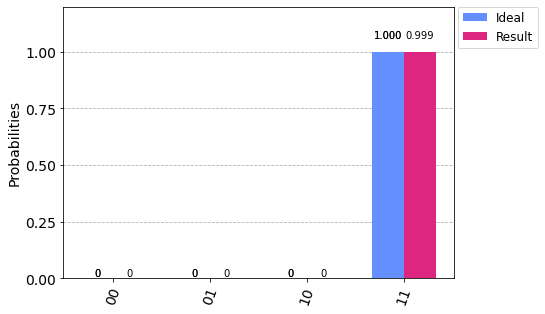

In [16]:
from qiskit import execute
from qiskit.visualization import plot_histogram

backend = BasicAer.get_backend('qasm_simulator')
count = execute(states[0], backend=backend, shots=10000).result().get_counts()
plot_histogram([ideal_dict[0], count],legend=['Ideal','Result'])

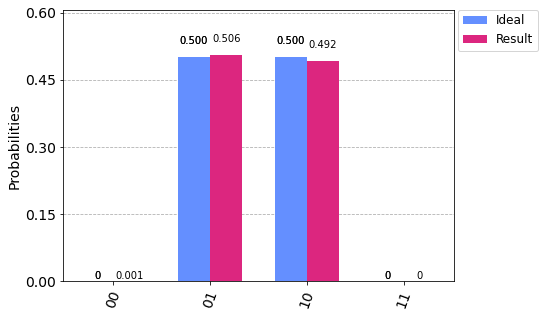

In [17]:
count = execute(states[1], backend=backend, shots=10000).result().get_counts()
plot_histogram([ideal_dict[1], count],legend=['Ideal','Result'])

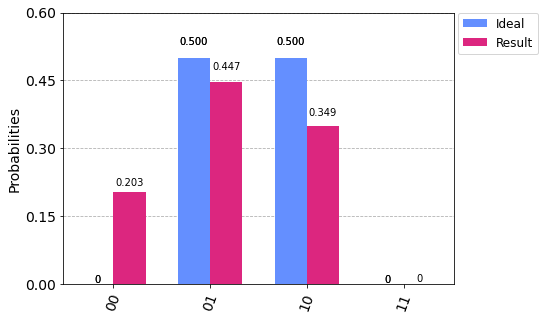

In [18]:
count = execute(states[2], backend=backend, shots=10000).result().get_counts()
plot_histogram([ideal_dict[2], count],legend=['Ideal','Result'])

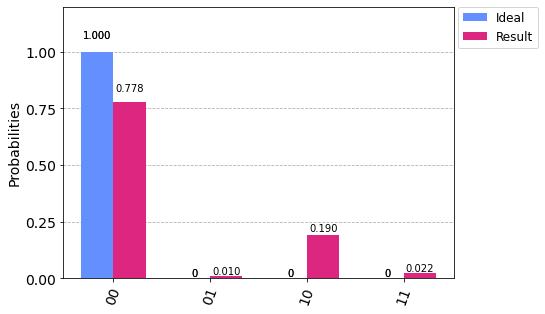

In [19]:
count = execute(states[3], backend=backend, shots=10000).result().get_counts()
plot_histogram([ideal_dict[3], count],legend=['Ideal','Result'])

In [20]:
eigenvalues

array([-3., -2.,  2.,  3.])

In [21]:
vqd_energies

[-3.0124999999999997, -1.9108999999999996, 2.4094000000000007, 3.863]

In [23]:
n_1_sim, n_2_sim = 1, 2
n_1_vqd, n_2_vqd = 1, 2
print(f"Gap Exact: {(eigenvalues[n_2_sim] - eigenvalues[n_1_sim])/2}")
print(f"Gap VQD: {(vqd_energies[n_2_vqd] - vqd_energies[n_1_vqd])/2}")

Gap Exact: 2.0
Gap VQD: 2.1601500000000002


# Varying epislon

In [10]:
from tqdm import tqdm

def hamiltonian_varying_eps(eps, V):
    energies_VQD = []
    energies_Classical = []
    
    for epsilons in tqdm(eps):
        hamiltonian = BCS_hamiltonian(epsilons, V)
        
        optimizer = COBYLA(maxiter=10000)
        backend = BasicAer.get_backend('qasm_simulator')

        Algo = VQD(hamiltonian=hamiltonian,
                    n_excited_states=1,
                    beta=3.,
                    optimizer=optimizer,
                    backend=backend)
        
        Algo.run(0)      
        uantum = Algo.energies
        energies_VQD.append([quantum[1], quantum[2]])
        classical = classical_solver(hamiltonian)
        energies_Classical.append([classical[1], classical[2]])
    
    return energies_VQD, energies_Classical

In [21]:
eps = [[1, 1.5], [1, 2.], [1, 2.5]]
V = -1.
energy_vqd, energy_classical = hamiltonian_varying_eps(eps, V)

100%|██████████| 5/5 [06:59<00:00, 85.62s/it]


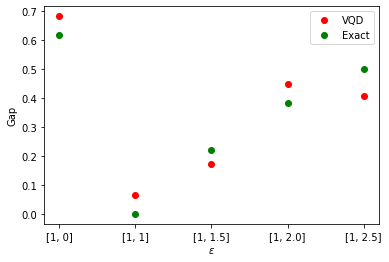

In [24]:
plt.plot([str(v) for v in eps], [value[1] - value[0] for value in energy_vqd], 'ro', label="VQD")
plt.plot([str(v) for v in eps], [value[1] - value[0] for value in energy_classical], 'go', label="Exact")
plt.xlabel('$\epsilon$')
plt.ylabel('Gap')
plt.legend()
plt.show()